# Clustering

## Library

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk import download
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
file_path = 'dataset.csv'
news_data = pd.read_csv(file_path)

news_data_info = news_data.info()
news_data_head = news_data.head()

news_data_info, news_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3897 entries, 0 to 3896
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  3897 non-null   object
dtypes: object(1)
memory usage: 30.6+ KB


(None,
                                             document
 0  From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
 1  From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
 2  From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
 3  From: ajs8@kimbark.uchicago.edu (adam jeremy s...
 4  From: npm@netcom.com (Nancy P. Milligan)\nSubj...)

In [3]:
download('punkt')        
download('wordnet')        
download('stopwords')    
download('omw-1.4')        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Preprocessing

In [13]:
lemmatizer = WordNetLemmatizer()
stop_words = ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

def clean_text(text, stop_words=stop_words):
    text = re.sub(r'\S+@\S+\.\S+', ' ', text)  
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
    text = re.sub(r'[\n\r\t]', ' ', text)  
    words = word_tokenize(text.lower())  
    cleaned_words = [
        word for word in words if word not in stop_words and len(word) > 2
    ]
    return ' '.join(cleaned_words)

news_data['cleaned_document'] = news_data['document'].apply(clean_text)

news_data[['document', 'cleaned_document']].head()

,document,cleaned_document
0,From: melabdel@cobra.cs.unm.edu (Mohammed Elab...,mohammed elabdellaoui subject europe muslim bo...
1,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...,mark ira kaufman subject israel kill reporters...
2,From: lundby@rtsg.mot.com (Walter F. Lundby)\n...,walter lundby subject msg sensitivity supersti...
3,From: ajs8@kimbark.uchicago.edu (adam jeremy s...,adam jeremy schorr subject graphics needed rep...
4,From: npm@netcom.com (Nancy P. Milligan)\nSubj...,nancy milligan subject need advice doctor pati...


## Feature extraction

In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')

feature_vectors = model.encode(news_data['cleaned_document'].tolist(), show_progress_bar=True)

X = np.array(feature_vectors)

print("Shape of feature vectors:", X.shape)

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

Shape of feature vectors: (3897, 384)


## K_means

Performing K-Means Clustering...


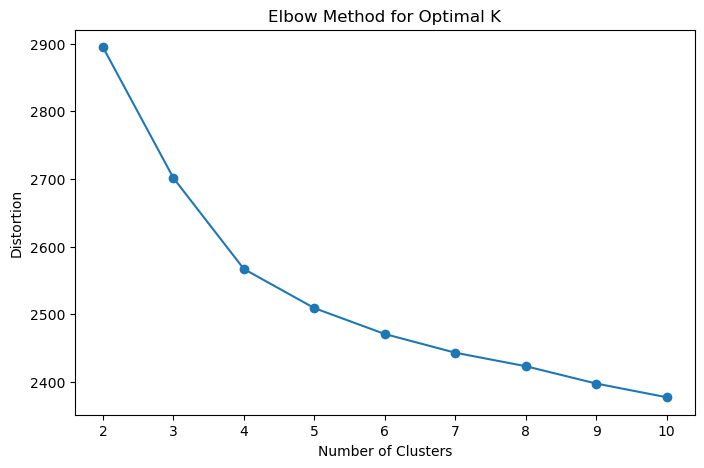

Enter the optimal number of clusters based on the elbow method: 4
Silhouette Score for K-Means: 0.1076


In [15]:
def perform_kmeans(X, max_clusters=10):
    distortions = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Method for Optimal K")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion")
    plt.show()

    optimal_k = int(input("Enter the optimal number of clusters based on the elbow method: "))
    kmeans = KMeans(n_clusters=optimal_k, n_init=50)
    kmeans_labels = kmeans.fit_predict(X)

    silhouette_avg = silhouette_score(X, kmeans_labels)
    print(f"Silhouette Score for K-Means: {silhouette_avg:.4f}")
    return kmeans_labels, silhouette_avg

print("Performing K-Means Clustering...")

kmeans_labels, kmeans_silhouette = perform_kmeans(X)

## DBSCAN

In [16]:
def perform_dbscan(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X)

    if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
        labels = dbscan_labels[dbscan_labels != -1]
        filtered_X = X[dbscan_labels != -1]
        silhouette_avg = silhouette_score(filtered_X, labels)
        print(f"Silhouette Score for DBSCAN (excluding noise): {silhouette_avg:.4f}")
    else:
        silhouette_avg = "Cannot compute (only one cluster or noise)"
        print(f"Silhouette Score for DBSCAN: {silhouette_avg}")
    return dbscan_labels

print("\nPerforming DBSCAN Clustering...")
dbscan_labels = perform_dbscan(X, eps=0.2, min_samples=3)


Performing DBSCAN Clustering...
Silhouette Score for DBSCAN (excluding noise): 0.8767


## Hierarchical

In [17]:
def perform_hierarchical(X, n_clusters):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    hierarchical_labels = hierarchical.fit_predict(X)

    silhouette_avg = silhouette_score(X, hierarchical_labels)
    print(f"Silhouette Score for Hierarchical Clustering: {silhouette_avg:.4f}")
    return hierarchical_labels, silhouette_avg

print("\nPerforming Hierarchical Clustering...")
hierarchical_labels, hierarchical_silhouette = perform_hierarchical(X, n_clusters=4)


Performing Hierarchical Clustering...
Silhouette Score for Hierarchical Clustering: 0.1039


## Visualize

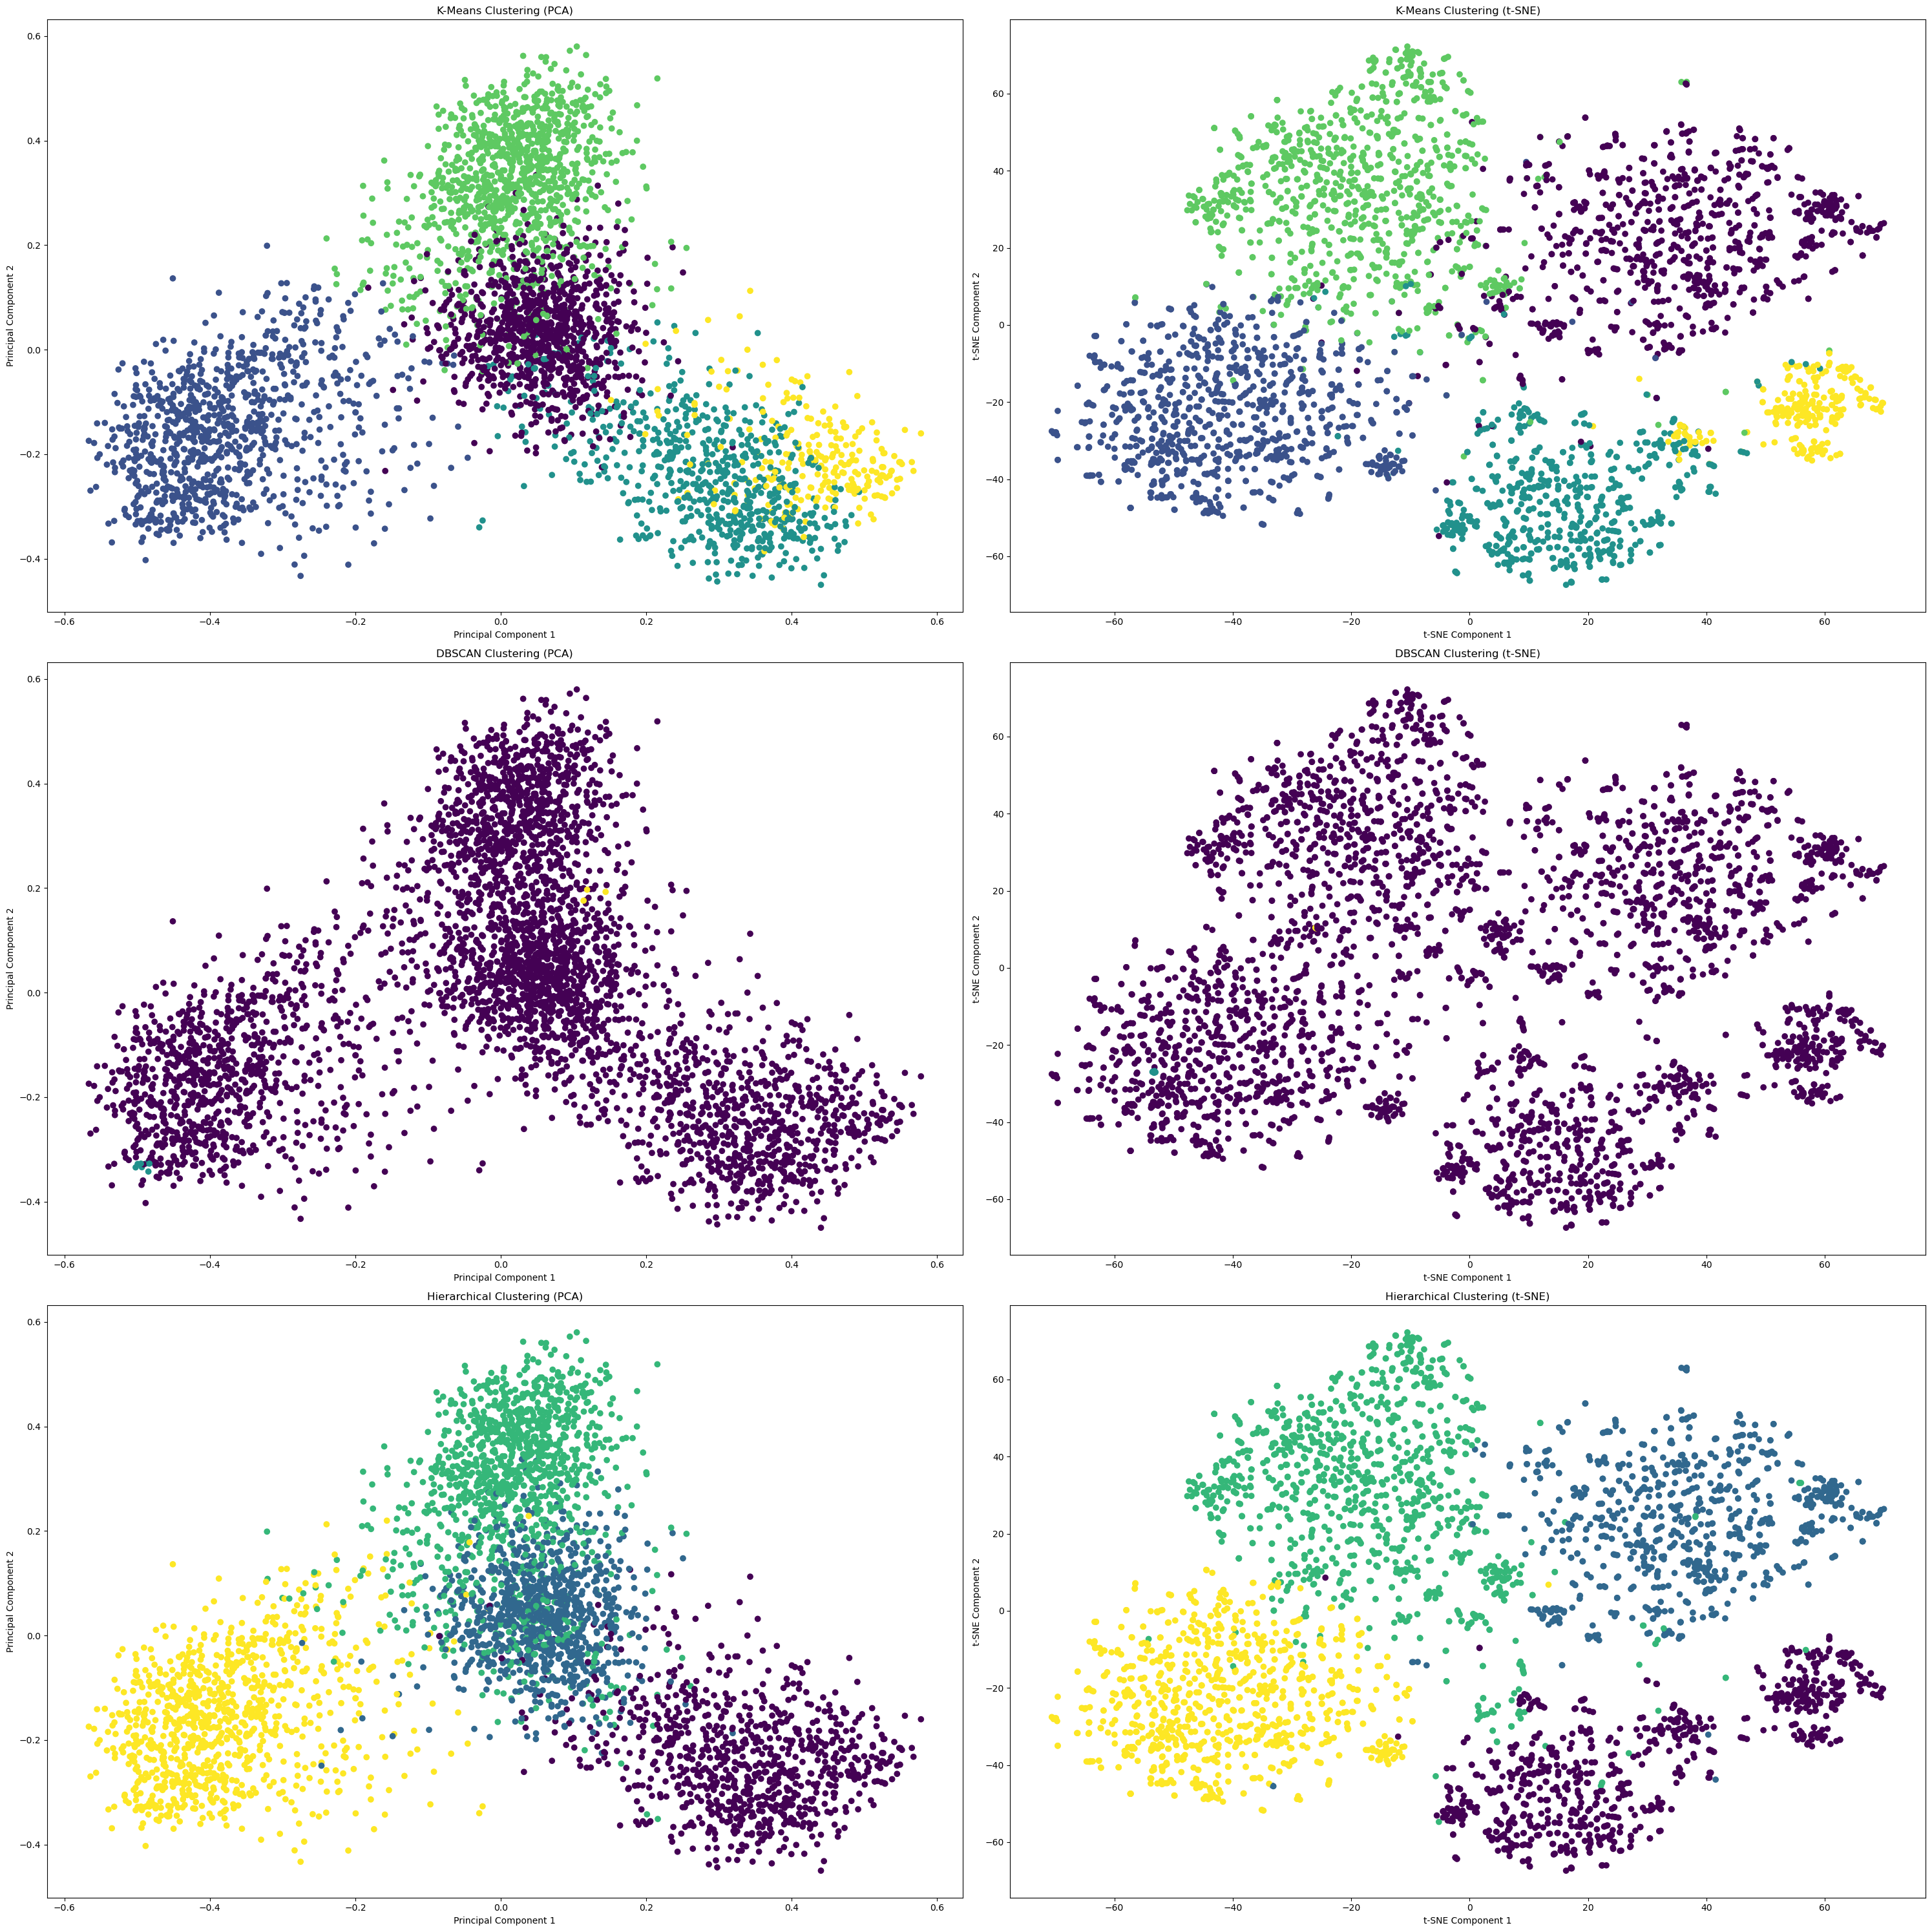

In [11]:
def visualize_clusters(X, kmeans_labels, dbscan_labels, hierarchical_labels):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    fig, axes = plt.subplots(3, 2, figsize=(30, 30))

    # K-Means (PCA)
    axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, marker='o')
    axes[0, 0].set_title("K-Means Clustering (PCA)")
    axes[0, 0].set_xlabel("Principal Component 1")
    axes[0, 0].set_ylabel("Principal Component 2")
    
    # K-Means (t-SNE)
    axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
    axes[0, 1].set_title("K-Means Clustering (t-SNE)")
    axes[0, 1].set_xlabel("t-SNE Component 1")
    axes[0, 1].set_ylabel("t-SNE Component 2")

    # DBSCAN (PCA)
    axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, marker='o')
    axes[1, 0].set_title("DBSCAN Clustering (PCA)")
    axes[1, 0].set_xlabel("Principal Component 1")
    axes[1, 0].set_ylabel("Principal Component 2")
    
    # DBSCAN (t-SNE)
    axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
    axes[1, 1].set_title("DBSCAN Clustering (t-SNE)")
    axes[1, 1].set_xlabel("t-SNE Component 1")
    axes[1, 1].set_ylabel("t-SNE Component 2")

    # Hierarchical (PCA)
    axes[2, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, marker='o')
    axes[2, 0].set_title("Hierarchical Clustering (PCA)")
    axes[2, 0].set_xlabel("Principal Component 1")
    axes[2, 0].set_ylabel("Principal Component 2")

    # Hierarchical (t-SNE)
    axes[2, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', marker='o')
    axes[2, 1].set_title("Hierarchical Clustering (t-SNE)")
    axes[2, 1].set_xlabel("t-SNE Component 1")
    axes[2, 1].set_ylabel("t-SNE Component 2")

    plt.tight_layout()
    plt.show()

visualize_clusters(X, kmeans_labels, dbscan_labels, hierarchical_labels)